# Machine Learning to explain the price of electricity

## Authors
- [Paul Zamanian](https://www.linkedin.com/in/paul-zamanian-abbassi-899126196)
- [Matthieu Vichet](https://www.linkedin.com/in/matthieu-vichet-4b31201a8)
- [Benjamin Rossignol](https://www.linkedin.com/in/benjamin-rossignol-4b92521b8)

## Summary

<span style="color:red">INSERT SUMMARY</span>

## Introduction
As of 2023, and since 10 years, the energy didn't stop from rising. In France, the soaring cost of electricity is a real problem for the population. The price of electricity is a complex subject, and it is difficult to understand the reasons for this increase. In this project, we will try to explain the price of electricity in France and Germany, and to predict the price of electricity in the future. So, we will try to answer the following questions:
- Can we fully explain the price of electricity?
- If so, what are the main factors that influence the price of electricity?
- What will be the price of electricity in the next few years?

We will write all the steps inside this notebook. We will use Python, and the libraries that we will use are Pandas, Matplotlib, Scikit-Learn.

## Data Description

Here, we have 3 datasets:

### Data_X

The first one corresponds to the price of electricity in France and Germany on a daily basis of approximately 1 000 days. It contains 35 columns, mainly:
- An ID
- The day number
- The country name. This variable seem to not have any purpose, as all the rows contains the FR and DE values. This means that we will have similar rows, for example:

    <span style="color:red">306</span>,207,<span style="color:red">DE</span>,-0.20246037737004818,-0.6330412335287392,...

    ...

    <span style="color:red">1522</span>,207,<span style="color:red">FR</span>,-0.20246037737004818,-0.6330412335287392,...

Here the only difference is the ID and country, the rest of the columns are the same. So, we will regroup the rows and delete the country column.

- **x_CONSUMPTION**: The energy consumption per country
- **x_y_EXCHANGE**: The energy exchange, how much energy is exchanged between FR and DE
- **x_NET_IMPORT/EXPORT**: The energy import/export
- **x_GAS/COAL/HYDRO/NUCLEAR/SOLAR/WINDPOW**: The energy production per country (mainly gas, coal, hydro, nuclear, solar, wind)
- **DE_LIGNITE**: The lignite production for Germany
- **x_RESIDUAL_LOAD**: The electricity consumption after using all renewable energies
- **x_RAIN/WIND/TEMP**: The weather data
- **GAS_RET/COAL_RET/CARBON_RET**: The gas, coal and carbon prices

There are a lot of variables, so focusing on the most important ones will be a good idea. But, what are the most important ones? Perhaps some of them are correlated, so we will have to check that.

### Data_Y

This data represents the **LEARNING** data. In fact, we have all the IDs from Data_X and the price of electricity for each ID. So, we will have to predict the price of electricity for each ID.

### DataNew_X

This data is similar to Data_X, but it is for different days. This is the dataset that we will try to predict. This is the **TESTING** data.

## Data Preparation

Our first step will be to initialize the two datasets, data_x and data_y. Here it is:

In [1]:
import pandas as pd

# Creating the two datasets
data_x: pd.DataFrame = pd.read_csv('data/Data_X.csv')
data_y: pd.DataFrame = pd.read_csv('data/Data_Y.csv')

# Print 5 columns of data
print(data_x.head())
print(data_y.head())

     ID  DAY_ID COUNTRY  DE_CONSUMPTION  FR_CONSUMPTION  DE_FR_EXCHANGE   
0  1054     206      FR        0.210099       -0.427458       -0.606523  \
1  2049     501      FR       -0.022399       -1.003452       -0.022063   
2  1924     687      FR        1.395035        1.978665        1.021305   
3   297     720      DE       -0.983324       -0.849198       -0.839586   
4  1101     818      FR        0.143807       -0.617038       -0.924990   

   FR_DE_EXCHANGE  DE_NET_EXPORT  FR_NET_EXPORT  DE_NET_IMPORT  ...   
0        0.606523            NaN       0.692860            NaN  ...  \
1        0.022063      -0.573520      -1.130838       0.573520  ...   
2       -1.021305      -0.622021      -1.682587       0.622021  ...   
3        0.839586      -0.270870       0.563230       0.270870  ...   
4        0.924990            NaN       0.990324            NaN  ...   

   FR_RESIDUAL_LOAD   DE_RAIN   FR_RAIN   DE_WIND   FR_WIND   DE_TEMP   
0         -0.444661 -0.172680 -0.556356 -0.790823

We can see that data now contains all the information from Data_X and Data_Y. As said before, we will merge the values from the same day, and delete the COUNTRY column. So we will have only one row per day. To do so, we will remove the duplicates in data_x, keep the IDs that we removed and also remove them from data_y:

In [2]:
# we remove the country column
data_x = data_x.drop(columns=['COUNTRY'])

# if two rows have the same day, we delete one of them
data_x = data_x.drop_duplicates(subset=['DAY_ID'], keep='first')

# now we have to delete the IDs that we removed from data_x
data_y = data_y[data_y['ID'].isin(data_x['ID'])]

# we will check by printing the shape of the two datasets
print(data_x.shape)
print(data_y.shape)

(851, 34)
(851, 2)


This is correct, we have the same number of rows in data_x and data_y.
Our next step is to check if there are any missing values:

In [3]:
print(data_x.isnull().sum())

ID                    0
DAY_ID                0
DE_CONSUMPTION        0
FR_CONSUMPTION        0
DE_FR_EXCHANGE       25
FR_DE_EXCHANGE       25
DE_NET_EXPORT       124
FR_NET_EXPORT        70
DE_NET_IMPORT       124
FR_NET_IMPORT        70
DE_GAS                0
FR_GAS                0
DE_COAL               0
FR_COAL               0
DE_HYDRO              0
FR_HYDRO              0
DE_NUCLEAR            0
FR_NUCLEAR            0
DE_SOLAR              0
FR_SOLAR              0
DE_WINDPOW            0
FR_WINDPOW            0
DE_LIGNITE            0
DE_RESIDUAL_LOAD      0
FR_RESIDUAL_LOAD      0
DE_RAIN              47
FR_RAIN              47
DE_WIND              47
FR_WIND              47
DE_TEMP              47
FR_TEMP              47
GAS_RET               0
COAL_RET              0
CARBON_RET            0
dtype: int64


As we can see, there are a lot of missing values. We will have to deal with them. We decided for this project, to delete the empty lines since we have a lot of data:

In [27]:
data_x = data_x.dropna()

# we then need to re-delete the values from the data_y dataset
data_y = data_y[data_y['ID'].isin(data_x['ID'])]

print(data_x.isnull().sum())

ID                  0
DAY_ID              0
DE_CONSUMPTION      0
FR_CONSUMPTION      0
DE_FR_EXCHANGE      0
FR_DE_EXCHANGE      0
DE_NET_EXPORT       0
FR_NET_EXPORT       0
DE_NET_IMPORT       0
FR_NET_IMPORT       0
DE_GAS              0
FR_GAS              0
DE_COAL             0
FR_COAL             0
DE_HYDRO            0
FR_HYDRO            0
DE_NUCLEAR          0
FR_NUCLEAR          0
DE_SOLAR            0
FR_SOLAR            0
DE_WINDPOW          0
FR_WINDPOW          0
DE_LIGNITE          0
DE_RESIDUAL_LOAD    0
FR_RESIDUAL_LOAD    0
DE_RAIN             0
FR_RAIN             0
DE_WIND             0
FR_WIND             0
DE_TEMP             0
FR_TEMP             0
GAS_RET             0
COAL_RET            0
CARBON_RET          0
dtype: int64


Now that there are no missing values, we will plot all the variables to see if there are any outliers.

Since the values are very different, we decided to normalize them. First, here are the histograms of all the variables:

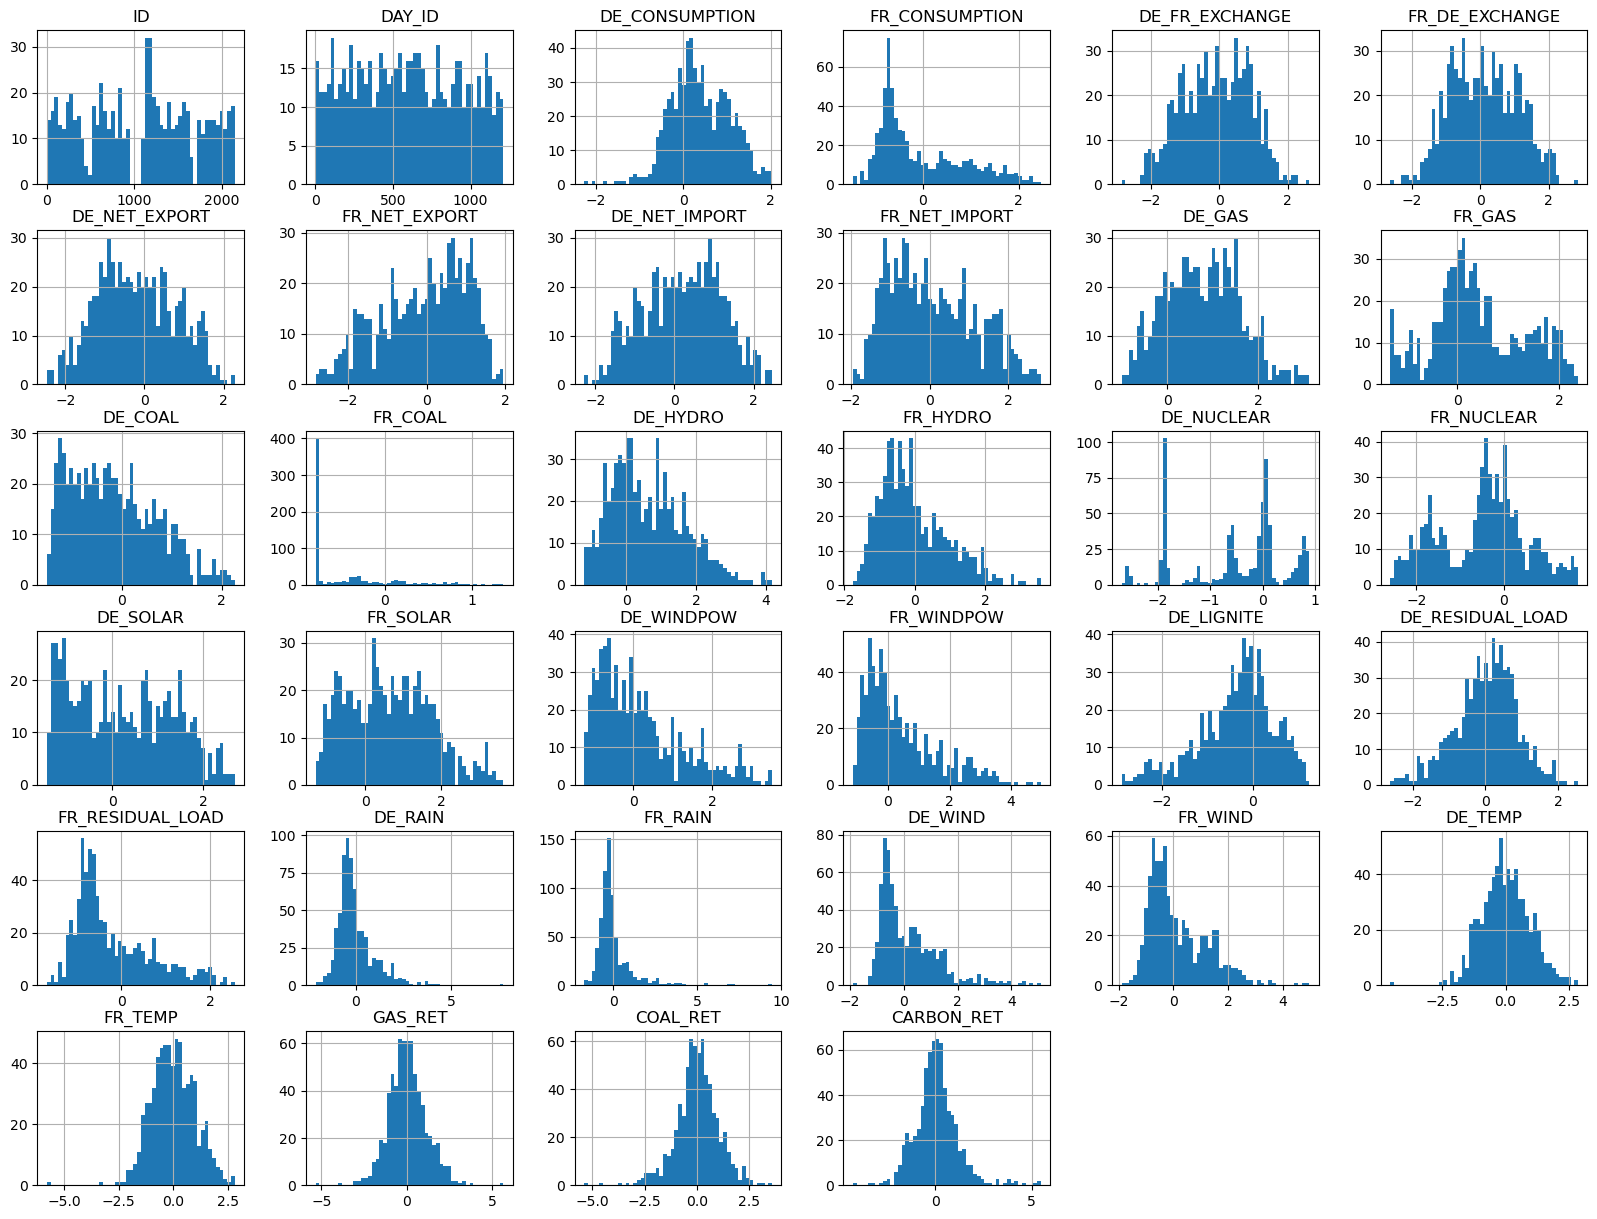

In [5]:
import matplotlib.pyplot as plt

# hist plot of all the variables
data_x.hist(bins=50, figsize=(20, 15))
plt.show()


The scales are a bit different, mainly between -5 and 5, but we can see that they look similar.
From [this link](https://medium.com/@aziszamcalvin/python-for-data-science-implementing-exploratory-data-analysis-eda-and-k-means-clustering-bcf1d24adc12), we can see that the data distribution can be described using the keywords: normal, skewed, uniform, bimodal, multimodal.
Then, the variables follow the following distributions:

| Variable         | Distribution        |
|------------------|---------------------|
| DE_CONSUMPTION   | Unimodal            |
| FR_CONSUMPTION   | Skew right          |
| DE_FR_EXCHANGE   | Unimodal            |
| FR_DE_EXCHANGE   | Unimodal            |
| DE_NET_IMPORT    | Skew left           |
| DE_NET_EXPORT    | Skew right          |
| FR_NET_IMPORT    | Skew right          |
| FR_NET_EXPORT    | Skew left           |
| DE_GAS           | Skew right          |
| FR_GAS           | Multimodal          |
| DE_COAL          | Skew right          |
| FR_COAL          | Spike right         |
| DE_HYDRO         | Skew right          |
| FR_HYDRO         | Skew right          |
| DE_NUCLEAR       | Multimodal          |
| FR_NUCLEAR       | Multimodal          |
| DE_SOLAR         | Multimodal          |
| FR_SOLAR         | Multimodal          |
| DE_WINDPOW       | Skew right          |
| FR_WINDPOW       | Skew right          |
| DE_LIGNITE       | Skew left           |
| DE_RESIDUAL_LOAD | Symmetric, unimodal |
| FR_RESIDUAL_LOAD | Skew right          |
| DE_RAIN          | Skew right          |
| FR_RAIN          | Skew right          |
| DE_WIND          | Skew right          |
| FR_WIND          | Skew right          |
| DE_TEMP          | Symmetric, unimodal |[^1]
| FR_TEMP          | Symmetric, unimodal |[^2]

[^1]: footnote 1
[^2]: footnote 2
Now, our two normalization scales are MinMax and Standard. To use standard, it is better to have a normal data distribution. Here, it is not always the case: some of them are close to normal, but some are not. So, to make it easier, we will use MinMax on every variable. Here is the code:

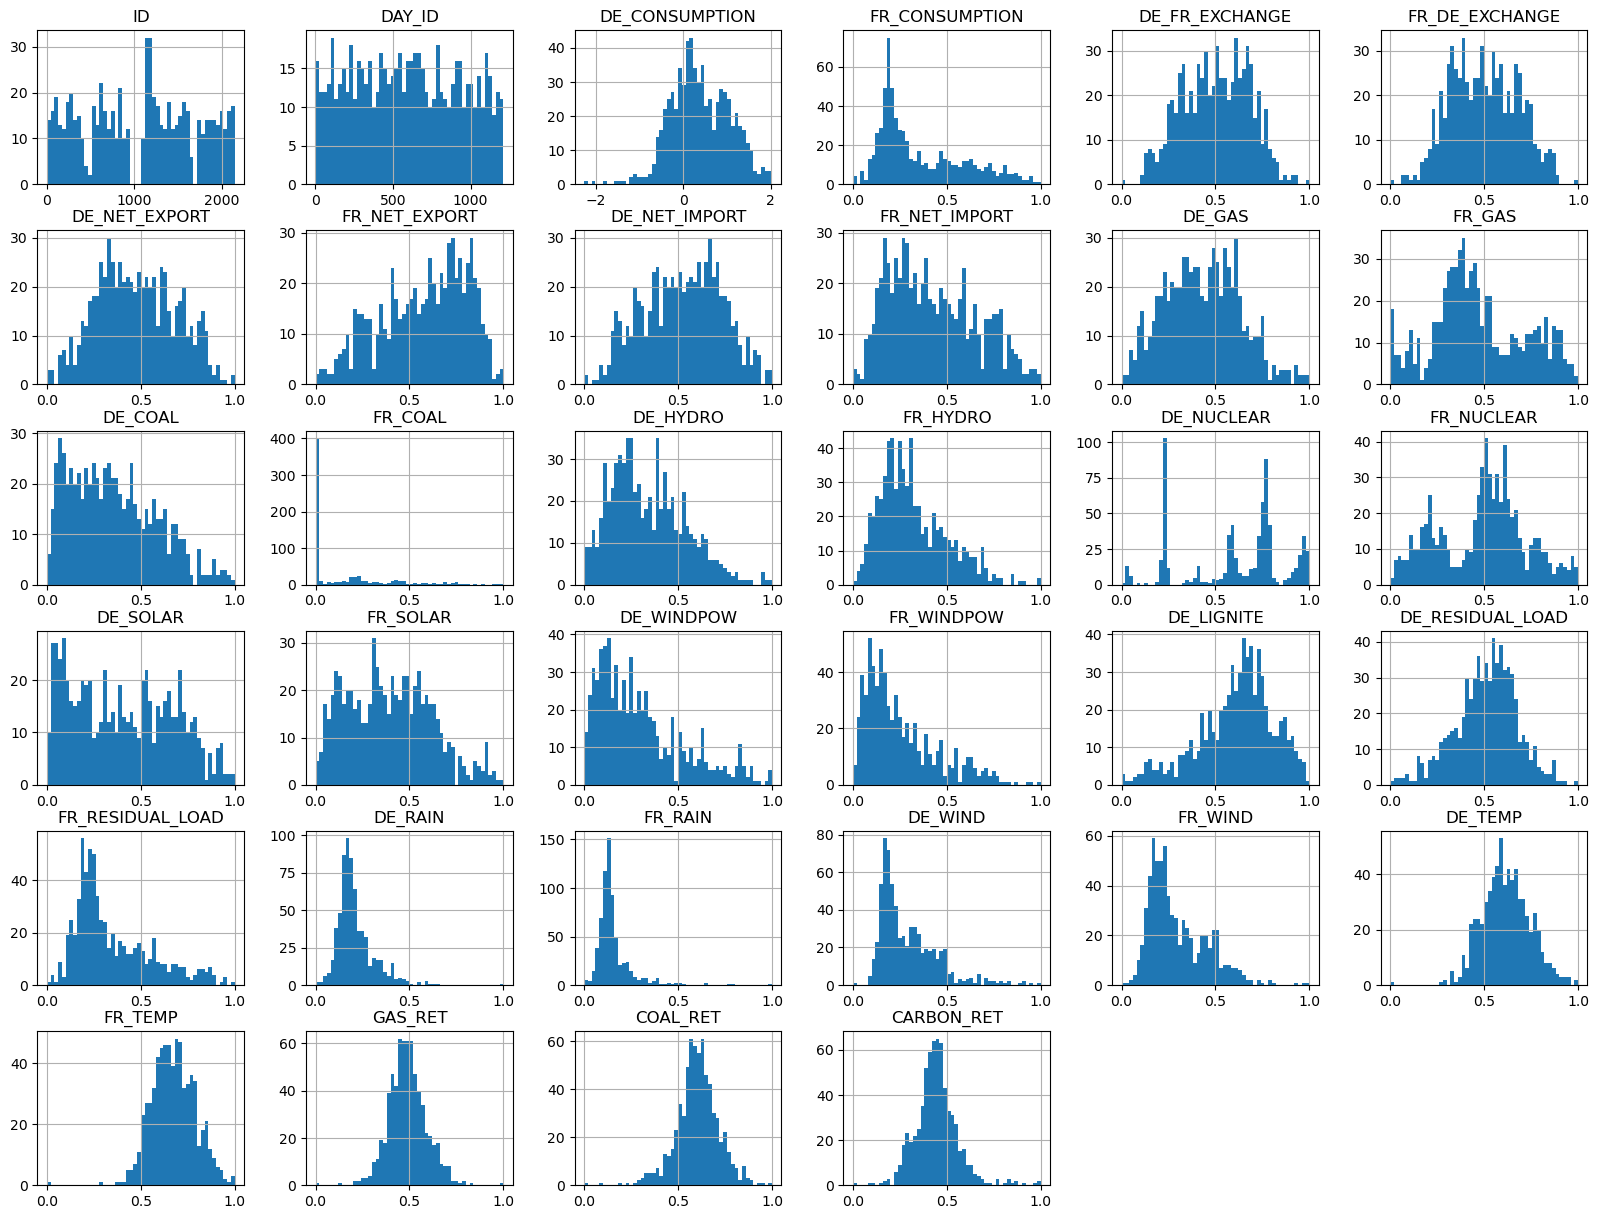

In [9]:
from sklearn.preprocessing import MinMaxScaler

# we will use MinMax on every variable except the ID, DAY_ID and COUNTRY (the 3 first columns)
# we will store the normalized data in normalized_data

scaler: MinMaxScaler = MinMaxScaler()
normalized_data: pd.DataFrame = data_x.copy()
normalized_data[normalized_data.columns[3:]] = scaler.fit_transform(normalized_data[normalized_data.columns[3:]])

# we will check by printing the histograms again
normalized_data.hist(bins=50, figsize=(20, 15))
plt.show()

The histograms look similar and the scales are now between 0 and 1.
It is also important to see what our goal is. We will plot the content of Data_Y:

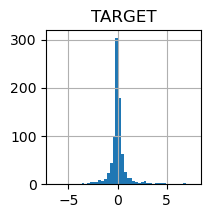

In [26]:
# show only TARGET
data_y.hist(bins=50, figsize=(2, 2), column='TARGET')
plt.show()

As we can see, the target variable follows a normal distribution. It is centered and symmetric.

## Exploratory Data Analysis

Now that our data is normalized, we will try to split the data to make categories out of the price of electricity. We will **CUT** the data into 5 categories:
- **Very Low**: 0 - 0.2
- **Low**: 0.2 - 0.4
- **Medium**: 0.4 - 0.6
- **High**: 0.6 - 0.8
- **Very High**: 0.8 - 1

We will use the **CUT** function from Pandas to do so:

In [11]:
# we will use "cut" to cut all columns except the first 2 (ID, DAY_ID). We will store the result in the same dataframe
normalized_data[normalized_data.columns[2:]] = normalized_data[normalized_data.columns[2:]].apply(pd.cut, bins=[0, 0.2, 0.4, 0.6, 0.8, 1], labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])


In [12]:
# we will check by printing data_x
print(data_x.head())

     ID  DAY_ID DE_CONSUMPTION FR_CONSUMPTION DE_FR_EXCHANGE FR_DE_EXCHANGE   
1  2049     501            NaN       Very Low         Medium         Medium  \
2  1924     687            NaN      Very High           High            Low   
3   297     720            NaN       Very Low            Low           High   
5  1520     467            NaN       Very Low            Low           High   
6  1546     144            NaN            Low         Medium         Medium   

  DE_NET_EXPORT FR_NET_EXPORT DE_NET_IMPORT FR_NET_IMPORT  ...   
1           Low           Low          High          High  ...  \
2           Low           Low          High          High  ...   
3        Medium          High        Medium           Low  ...   
5           Low        Medium          High        Medium  ...   
6        Medium           Low        Medium          High  ...   

  FR_RESIDUAL_LOAD   DE_RAIN   FR_RAIN   DE_WIND   FR_WIND DE_TEMP    FR_TEMP   
1         Very Low  Very Low  Very Low    Mediu